Dataset: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016

In [456]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=0.5)


pd.options.display.max_columns = 150

df = pd.read_csv('data/mental.csv')

In [457]:
new_column_names = ['is_self_employed', 'employee_count_bracket', 'is_tech_org', 'role_is_IT', 'empl_provides_mh_cov', 'knows_mh_cov_options',
                    'empl_discussed_mh','empl_offers_mh_rsrcs','anon_protec','if_askfor_mh_medical_leave_how_easy', 'discuss_mh_with_empl_wouldcause_neg_conseq', 'discuss_ph_with_empl_wouldcause_neg_conseq',
                    'comfy_discussing_mh_with_coworkers','comfy_discussing_mh_with_supervisors' , 'empl_takes_mh_asseriously_as_ph', 'observed_neg_conseq_for_coworkers_openabout_mh_inworkspace',
                    'has_medical_cov_incl_mh', 'knowsof_mh_resources','if_diag_would_reveal_toclients/bn_contacts', 'if_reveal_diag_toclient_didthis_impact_neg', 'if_diag_would_reveal_tocoworkers/employees',
                    'if_reveal_diag_tocoworker_didthis_impact_neg', 'productivity_isaffected_by_mh', 'percentage_worktime_affected_by_mh', 'has_prev_employers','prev_empl_provided_mh_benefits',
                    'was_aware_of_prevemployers_mhcare_options','prev_empl_discussed_mh', 'prev_empl_provided_mh_rsrc', 'prev_anon_protec', 'prev_discuss_mh_with_empl_wouldcause_neg_conseq',
                    'prev_discuss_ph_with_empl_wouldcause_neg_conseq', 'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors',
                    'prev_empl_takes_mh_asseriously_as_ph', 'prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace', 'willingto_bringup_ph_interview', 'why', 'willingto_bringup_mh_interview',
                    'why2', 'believes_beingident_as_mh_wouldhurt_career', 'thinks_coworkers_wouldviewthem_neg_if_mh', 'howwilling_share_mh_with_friendsfamily',
                    'observed_badly_handled_response_to_mh_inworkplace', 'observed_madethem_notwantto_talk_about_mh', 'has_family_history_mh', 'hashad_mh_inpast', 'HAS_MH', 'diagnoses_notprof',
                    'conditions_suspected', 'hasbeen_diag_byprof', 'diagnoses_prof', 'sought_treatment', 'mh_interferes_w/work_effective_trt', 'mh_interferes_w/work_ineffective_trt',
                    'age', 'sex', 'country_livesin', 'us_state_livesin', 'country_worksin', 'us_state_worksin', 'work_position', 'is_remote_working']

df.columns = new_column_names

In [458]:
"""Dropping stuff"""


why_cols = [columns for columns in df.columns if 'why' in columns]

#dropping 'why' questions, as each one of them is too unique
for column in why_cols:
    df.drop(column, axis='columns', inplace=True)

#most people (all but 26) work in the same country as they live. this info will still be preserved in remote working column. dropping the country_livesin_column
df.drop('country_livesin', axis='columns', inplace=True)

df.drop(['us_state_livesin', 'us_state_worksin', 'diagnoses_prof'], axis='columns', inplace=True)

#dropping rows with 25 missing values or more
df = df.loc[df.isna().sum(axis=1) < 25]

#dropping columns with clear majority missing values
df.drop(['knowsof_mh_resources', 'if_diag_would_reveal_toclients/bn_contacts', 'if_reveal_diag_toclient_didthis_impact_neg', 'if_diag_would_reveal_tocoworkers/employees', 'if_reveal_diag_tocoworker_didthis_impact_neg',
         'productivity_isaffected_by_mh','percentage_worktime_affected_by_mh'], axis='columns', inplace=True)

#dropping non-professional and self-diagnoses - 1. because mostly are missing anyway and 2. self diagnoses can are very innaccurate
df.drop(['diagnoses_notprof', 'conditions_suspected'], axis='columns', inplace=True)

In [459]:
#Replacing gender names to a male/female/other convention
df['sex'].replace(to_replace=['Male', 'male', 'Male ','M','m','man','Male.','male 9:1 female, roughly','Male (cis)','Sex is male','Man',
                              'cis male','Malr','Dude',"I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
                              'mail', 'M|', 'Male/genderqueer','male ','Cis Male', 'Male (trans, FtM)','cisdude','cis man','MALE','Cis male'], value='MALE', inplace=True)

df['sex'].replace(to_replace=['Female', 'female', 'I identify as female.','female ','Female assigned at birth ','F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
                                        'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman','Cisgender Female','genderqueer woman','mtf','fem', 'Female (props for making this a freeform field, though)',
                                        ' Female','Cis-woman','Transgender woman'
                                        ],value='FEMALE', inplace=True)

df['sex'].replace(to_replace=['Bigender', 'non-binary',
       'Genderfluid (born female)', 'Other/Transfeminine', 'Androgynous', 'Other', 'nb masculine', 'none of your business',
       'genderqueer', 'Human', 'Genderfluid', 'Enby', 'Queer', 'Agender',
       'Fluid', 'Nonbinary', 'human', 'Unicorn', 'Genderqueer',
       'Genderflux demi-girl', 'female-bodied; no feelings about gender',
       'AFAB'], value='OTHER', inplace=True)

In [460]:
def show_value_counts(df):
    for column in df.columns:
        print(df[column].value_counts(), end='\n\n')

In [461]:
def get_unique_conditions(cond_series):
    conditions = cond_series.unique()

    condition_unsep = set()
    for condition in conditions:
        condition_unsep.add(condition)

    condition_set = set()
    pipes = []

    for condition in condition_unsep:
        if '|' in condition:
            pipes.append(condition.split('|'))
        else:
            condition_set.add(condition)

    for cond_list in pipes:
        for cond in cond_list:
            condition_set.add(cond)
    
    return list(condition_set)

In [462]:
#manually added based on unique_diagnosed_conditions_by_prof - faster to discern the actually unqique ones by hand
actually_unique_by_prof = set(['Autism Spectrum Disorder', 'Mood disorder', 'PTSD', 'PDD-NOS', 'Addictive Disorder', 'ADHD', 'ADD',
                   'Anxiety Disorder', 'Burnout', 'Dissociative Disorder', 'Eating Disorder', 'Gender Dysphoria', 
                   'Gender Identity Disorder', 'Intimate Disorder', 'MCD', 'OCD', 'Personality Disorder', 'Psychotic Disorder',
                   'SAD', 'Stress Response Syndromes','Substance Use Disorder','Suicidal Ideation'])


In [463]:
#majority from USA, UK, CD, GER, NED, AUS - dropping others for now
df['country_worksin'].value_counts()
df = df.loc[df['country_worksin'].isin(['United States of America', 'United Kingdom', 'Canada', 'Germany', 'Netherlands', 'Australia'])]

In [464]:
get_unique_conditions(df['work_position'])

tech_roles = ['Back-end Developer', 'Front-end Developer','DevOps/SysAdmin', 'Dev Evangelist/Advocate']

joined = '|'.join(tech_roles)


In [465]:
def has_tech_role(row):
    
    tech_roles = ['Back-end Developer', 'Front-end Developer','DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    
    for role in tech_roles:
        if role in row['work_position']:
            return 'Yes'
    
    return 'No'

df['has_tech_role'] = df.apply(lambda row: has_tech_role(row), axis=1)
df.drop('role_is_IT', axis='columns', inplace=True)

In [466]:
def get_new_bracket(row):
    bracket = row['employee_count_bracket']
    
    if bracket in ['1-5', '6-25']:
        return '1-25'
    
    elif bracket in ['26-100', '100-500']:
        return '26-500'
    
    elif bracket in ['500-1000', 'More than 1000']:
        return '500 or more'
    
    else:
        return bracket
        

df['employee_count_bracket'] = df.apply(lambda row: get_new_bracket(row), axis=1) 

In [467]:
#columns that will have missing values for self-employed respondents (209 people)
excluded_for_self_employed = ['employee_count_bracket', 'empl_provides_mh_cov', 'is_tech_org', 'empl_discussed_mh', 'empl_offers_mh_rsrcs',
                               'anon_protec', 'if_askfor_mh_medical_leave_how_easy', 'discuss_mh_with_empl_wouldcause_neg_conseq',
                              'discuss_ph_with_empl_wouldcause_neg_conseq', 'comfy_discussing_mh_with_coworkers', 'comfy_discussing_mh_with_supervisors',
                              'empl_takes_mh_asseriously_as_ph', 'observed_neg_conseq_for_coworkers_openabout_mh_inworkspace', 'observed_badly_handled_response_to_mh_inworkplace']

#columns that will have missing values for respondents with no previous employers (104 people)
excluded_for_no_prev_employers = ['prev_empl_provided_mh_benefits', 'was_aware_of_prevemployers_mhcare_options', 'prev_empl_discussed_mh', 'prev_empl_provided_mh_rsrc',
                                  'prev_anon_protec', 'prev_discuss_mh_with_empl_wouldcause_neg_conseq', 'prev_discuss_ph_with_empl_wouldcause_neg_conseq',
                                  'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors', 'prev_empl_takes_mh_asseriously_as_ph',
                                  'prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace']

In [468]:
#replacing the relevant missing values with 'N/A' - not applicable
df.loc[df['is_self_employed'] == 1,       excluded_for_self_employed] = df.loc[df['is_self_employed'] == 1, excluded_for_self_employed].fillna("N/A")
df.loc[df['has_prev_employers'] == 0, excluded_for_no_prev_employers] = df.loc[df['has_prev_employers'] == 0, excluded_for_no_prev_employers].fillna("N/A")

In [469]:
def get_comfy_ppl_atwork(row):
    comfy_with_coworkers = row['comfy_discussing_mh_with_coworkers']
    comfy_with_supervisors = row['comfy_discussing_mh_with_supervisors']
    
    if comfy_with_coworkers == comfy_with_supervisors:
        return comfy_with_supervisors
    
    elif {comfy_with_supervisors, comfy_with_coworkers} == {'Yes', 'Maybe'}:
        return 'Maybe'

    else:
        return comfy_with_coworkers

#this dilutes these 2 columns a bit, but dimensionality reduction here is priority
df['comfy_discussing_mh_with_ppl_atwork'] = df.apply(lambda row: get_comfy_ppl_atwork(row), axis=1)
df.drop(['comfy_discussing_mh_with_supervisors', 'comfy_discussing_mh_with_coworkers'], axis='columns', inplace=True)

In [470]:
#filling in the 3 remaining with male - safest bet as the overwhelming majority of the respondents are male
df.loc[pd.isna(df['sex']), 'sex'] = df.loc[pd.isna(df['sex']), 'sex'].fillna('MALE')

#assuming the 323 age is a typo on 32
df.loc[df['age'] == 323, 'age'] = 32

#assuming the 3 age is a typo also, filling it in with 30, as it's the mode
df.loc[df['age'] == 30, 'age'] = 30

In [471]:
df.loc[pd.isna(df['observed_badly_handled_response_to_mh_inworkplace'])] = df.loc[pd.isna(df['observed_badly_handled_response_to_mh_inworkplace'])].fillna("Maybe/Not sure")

In [472]:
empl_cov_yes_filt = (pd.isna(df['has_medical_cov_incl_mh'])) & (df['empl_provides_mh_cov'] == 'Yes')

#Filling in the missing values for medical coverage - if the employer provides it, means they have it
#df.loc[empl_cov_yes_filt, "has_medical_cov_incl_mh" ] = df.loc[empl_cov_yes_filt, "has_medical_cov_incl_mh" ].fillna(1.0)

#dropping med coverage for now and remaining missing val columns- even with the above commented out step, we still end up with almost 500 missing values
df.drop(['has_medical_cov_incl_mh', 'knows_mh_cov_options', 'observed_madethem_notwantto_talk_about_mh'], axis='columns', inplace=True)

In [473]:
columns_to_not_encode = ['is_self_employed', 'has_prev_employers', 'sought_treatment', 'age', 'work_position']
to_encode = [col for col in df.columns if col not in columns_to_not_encode]

#DROPPING WORK POSITION FOR NOW
df.drop('work_position', axis='columns', inplace=True)

In [474]:
#The following is replacing some of the survey answers with more general ones - we do this because it increases the variance in the respective columns while preserving the underlying information
#A lot of the possible answers, while being different, carry barely any additional useful info as well as blowing up the number of columns after OHE

df['prev_empl_provided_mh_benefits'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['if_askfor_mh_medical_leave_how_easy'].replace({'Somewhat easy': 'Easy', 'Very easy': 'Easy', 'Somewhat difficult': 'Difficult', 'Very difficult': 'Difficult'}, inplace=True)
df['was_aware_of_prevemployers_mhcare_options'].replace({'I was aware of some': 'I was aware', 'Yes, I was aware of all of them': 'I was aware'}, inplace=True)
df['prev_empl_discussed_mh'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_empl_provided_mh_rsrc'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['was_aware_of_prevemployers_mhcare_options'].replace({'N/A (not currently aware)': 'N/A'}, inplace=True)
df['prev_anon_protec'].replace({'Sometimes': 'Yes', 'Yes, always': 'Yes'}, inplace=True)
df['prev_discuss_mh_with_empl_wouldcause_neg_conseq'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['prev_discuss_ph_with_empl_wouldcause_neg_conseq'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['prev_wouldhavebeen_willing_discuss_mh_coworkers'].replace({'Some of my previous employers': 'Some or all of my previous employers', 'Yes, at all of my previous employers': 'Some or all of my previous employers'}, inplace=True)
df['prev_wouldhavebeen_willing_discuss_mh_supervisors'].replace({'Some of my previous employers': 'Some or all of my previous employers', 'Yes, at all of my previous employers': 'Some or all of my previous employers'}, inplace=True)
df['prev_empl_takes_mh_asseriously_as_ph'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['believes_beingident_as_mh_wouldhurt_career'].replace({'Yes, it has': 'Yes, I think it would', 'No, it has not': "No, I don't think it would"}, inplace=True)
df['thinks_coworkers_wouldviewthem_neg_if_mh'].replace({'No, they do not': "No, I don't think they would", 'Yes, they do': 'Yes, I think they would'}, inplace=True)
df['howwilling_share_mh_with_friendsfamily'].replace({'Somewhat open': 'Open', 'Very open': 'Open', 'Somewhat not open': 'Not open', 'Not open at all': 'Not open'}, inplace=True)
df['mh_interferes_w/work_ineffective_trt'].replace({'Never': 'Rarely'}, inplace=True)
df['observed_badly_handled_response_to_mh_inworkplace'].replace({'Yes, I observed': 'Yes, I observed or experienced', 'Yes, I experienced': 'Yes, I observed or experienced'}, inplace=True)

In [475]:
df['is_tech_org'].replace({0.0: 'No', 1.0: 'Yes'}, inplace=True)
df['is_self_employed'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['has_prev_employers'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['sought_treatment'].replace({0: 'No', 1: 'Yes'}, inplace=True)

In [476]:
scaled_age = StandardScaler().fit_transform(df['age'].array.reshape(-1,1))

df.drop('age', axis='columns', inplace=True)
df['scaled_age'] = scaled_age

In [477]:
df

,is_self_employed,employee_count_bracket,is_tech_org,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,anon_protec,if_askfor_mh_medical_leave_how_easy,discuss_mh_with_empl_wouldcause_neg_conseq,discuss_ph_with_empl_wouldcause_neg_conseq,empl_takes_mh_asseriously_as_ph,observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,has_prev_employers,prev_empl_provided_mh_benefits,was_aware_of_prevemployers_mhcare_options,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_anon_protec,prev_discuss_mh_with_empl_wouldcause_neg_conseq,prev_discuss_ph_with_empl_wouldcause_neg_conseq,prev_wouldhavebeen_willing_discuss_mh_coworkers,prev_wouldhavebeen_willing_discuss_mh_supervisors,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,willingto_bringup_ph_interview,willingto_bringup_mh_interview,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,hashad_mh_inpast,HAS_MH,hasbeen_diag_byprof,sought_treatment,mh_interferes_w/work_effective_trt,mh_interferes_w/work_ineffective_trt,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,scaled_age
0,No,26-500,Yes,Not eligible for coverage / N/A,No,No,I don't know,Easy,No,No,I don't know,No,Yes,"No, none did",N/A,I don't know,None did,I don't know,Some or all of them,None of them,Some or all of my previous employers,Some or all of my previous employers,I don't know,None of them,Maybe,Maybe,Maybe,"No, I don't think they would",Open,No,No,Yes,No,Yes,No,Not applicable to me,Not applicable to me,MALE,United Kingdom,Sometimes,Yes,Maybe,0.555333
1,No,1-25,Yes,No,Yes,Yes,Yes,Easy,No,No,Yes,No,Yes,Some or all did,I was aware,None did,Some or all did,Yes,None of them,None of them,"No, at none of my previous employers",Some or all of my previous employers,Some or all did,None of them,Maybe,No,"No, I don't think it would","No, I don't think they would",Open,No,Yes,Yes,Yes,Yes,Yes,Rarely,Sometimes,MALE,United States of America,Never,Yes,Maybe,-0.632925
2,No,1-25,Yes,No,No,No,I don't know,Neither easy nor difficult,Maybe,No,I don't know,No,Yes,"No, none did",N/A,None did,Some or all did,I don't know,I don't know,Some or all of them,Some or all of my previous employers,I don't know,I don't know,Some or all of them,Yes,Yes,Maybe,Maybe,Open,Maybe/Not sure,No,Maybe,No,No,Yes,Not applicable to me,Not applicable to me,MALE,United Kingdom,Always,Yes,Maybe,0.436507
3,Yes,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,Some or all did,N/A,None did,None did,I don't know,Some or all of them,Some or all of them,Some or all of my previous employers,Some or all of my previous employers,I don't know,Some or all of them,Yes,Maybe,"Yes, I think it would",Maybe,Neutral,No,No,Yes,Yes,Yes,Yes,Sometimes,Sometimes,MALE,United Kingdom,Sometimes,No,N/A,1.030636
4,No,1-25,No,Yes,No,No,No,Neither easy nor difficult,Yes,Maybe,No,No,Yes,I don't know,N/A,Some or all did,None did,I don't know,Some or all of them,Some or all of them,"No, at none of my previous employers",Some or all of my previous employers,Some or all did,Some or all of them,Maybe,No,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Sometimes,Sometimes,FEMALE,United States of America,Sometimes,Yes,Maybe,1.030636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,No,500 or more,Yes,Yes,No,No,Yes,Easy,No,No,Yes,No,Yes,Some or all did,I was aware,None did,None did,I don't know,Some or all of them,None of them,Some or all of my previous employers,"No, at none of my previous employers",None did,Some or all of them,No,No,Maybe,"No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Rarely,Often,FEMALE,United States of America,Always,No,Yes,0.436507


In [478]:
encoded = pd.get_dummies(df, dtype=float, drop_first=True)

In [479]:


#dropping the _N/A columns - these only reflect the self employed/no previous employers people - this info will be maintained in the respective columns
for column in encoded.columns:
    if '_N/A' in column:
        encoded.drop(column, axis='columns', inplace=True)

#dropping columns for which the opposite is easy to infer (that doesn't happen for most). sex 'other' can be infered from 0 for male and 0 for female
#to_drop_in_encoded = ['is_tech_org_0.0', 'observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_No', 'hasbeen_diag_byprof_No', 'has_tech_role_0', 'sex_OTHER']

#encoded.drop(to_drop_in_encoded, axis='columns', inplace=True)

In [480]:
encoded

,scaled_age,is_self_employed_Yes,employee_count_bracket_26-500,employee_count_bracket_500 or more,is_tech_org_No,is_tech_org_Yes,empl_provides_mh_cov_No,empl_provides_mh_cov_Not eligible for coverage / N/A,empl_provides_mh_cov_Yes,empl_discussed_mh_No,empl_discussed_mh_Yes,empl_offers_mh_rsrcs_No,empl_offers_mh_rsrcs_Yes,anon_protec_No,anon_protec_Yes,if_askfor_mh_medical_leave_how_easy_Easy,if_askfor_mh_medical_leave_how_easy_I don't know,if_askfor_mh_medical_leave_how_easy_Neither easy nor difficult,discuss_mh_with_empl_wouldcause_neg_conseq_No,discuss_mh_with_empl_wouldcause_neg_conseq_Yes,discuss_ph_with_empl_wouldcause_neg_conseq_No,discuss_ph_with_empl_wouldcause_neg_conseq_Yes,empl_takes_mh_asseriously_as_ph_No,empl_takes_mh_asseriously_as_ph_Yes,observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_No,observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_Yes,has_prev_employers_Yes,"prev_empl_provided_mh_benefits_No, none did",prev_empl_provided_mh_benefits_Some or all did,"was_aware_of_prevemployers_mhcare_options_No, I only became aware later",prev_empl_discussed_mh_None did,prev_empl_discussed_mh_Some or all did,prev_empl_provided_mh_rsrc_None did,prev_empl_provided_mh_rsrc_Some or all did,prev_anon_protec_No,prev_anon_protec_Yes,prev_discuss_mh_with_empl_wouldcause_neg_conseq_None of them,prev_discuss_mh_with_empl_wouldcause_neg_conseq_Some or all of them,prev_discuss_ph_with_empl_wouldcause_neg_conseq_None of them,prev_discuss_ph_with_empl_wouldcause_neg_conseq_Some or all of them,"prev_wouldhavebeen_willing_discuss_mh_coworkers_No, at none of my previous employers",prev_wouldhavebeen_willing_discuss_mh_coworkers_Some or all of my previous employers,"prev_wouldhavebeen_willing_discuss_mh_supervisors_No, at none of my previous employers",prev_wouldhavebeen_willing_discuss_mh_supervisors_Some or all of my previous employers,prev_empl_takes_mh_asseriously_as_ph_None did,prev_empl_takes_mh_asseriously_as_ph_Some or all did,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_None of them,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_Some or all of them,willingto_bringup_ph_interview_No,willingto_bringup_ph_interview_Yes,willingto_bringup_mh_interview_No,willingto_bringup_mh_interview_Yes,"believes_beingident_as_mh_wouldhurt_career_No, I don't think it would","believes_beingident_as_mh_wouldhurt_career_Yes, I think it would","thinks_coworkers_wouldviewthem_neg_if_mh_No, I don't think they would","thinks_coworkers_wouldviewthem_neg_if_mh_Yes, I think they would",howwilling_share_mh_with_friendsfamily_Not applicable to me (I do not have a mental illness),howwilling_share_mh_with_friendsfamily_Not open,howwilling_share_mh_with_friendsfamily_Open,observed_badly_handled_response_to_mh_inworkplace_No,"observed_badly_handled_response_to_mh_inworkplace_Yes, I observed or experienced",has_family_history_mh_No,has_family_history_mh_Yes,hashad_mh_inpast_No,hashad_mh_inpast_Yes,HAS_MH_No,HAS_MH_Yes,hasbeen_diag_byprof_Yes,sought_treatment_Yes,mh_interferes_w/work_effective_trt_Not applicable to me,mh_interferes_w/work_effective_trt_Often,mh_interferes_w/work_effective_trt_Rarely,mh_interferes_w/work_effective_trt_Sometimes,mh_interferes_w/work_ineffective_trt_Often,mh_interferes_w/work_ineffective_trt_Rarely,mh_interferes_w/work_ineffective_trt_Sometimes,sex_MALE,sex_OTHER,country_worksin_Canada,country_worksin_Germany,country_worksin_Netherlands,country_worksin_United Kingdom,country_worksin_United States of America,is_remote_working_Never,is_remote_working_Sometimes,has_tech_role_Yes,comfy_discussing_mh_with_ppl_atwork_No,comfy_discussing_mh_with_ppl_atwork_Yes
0,0.555333,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0

In [481]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.18)

new = selector.fit_transform(encoded)

features = selector.get_support(indices=True)
columns = encoded.columns[features]

selected = pd.DataFrame(new, columns=columns)

In [483]:
no_age = selected.drop('scaled_age', axis='columns')

In [484]:
from sklearn.manifold import TSNE

tsne_df = pd.DataFrame(TSNE(n_components=2, metric='jaccard', perplexity=35, random_state=4).fit_transform(no_age))

/home/wojciech/.local/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<Axes: xlabel='0', ylabel='1'>

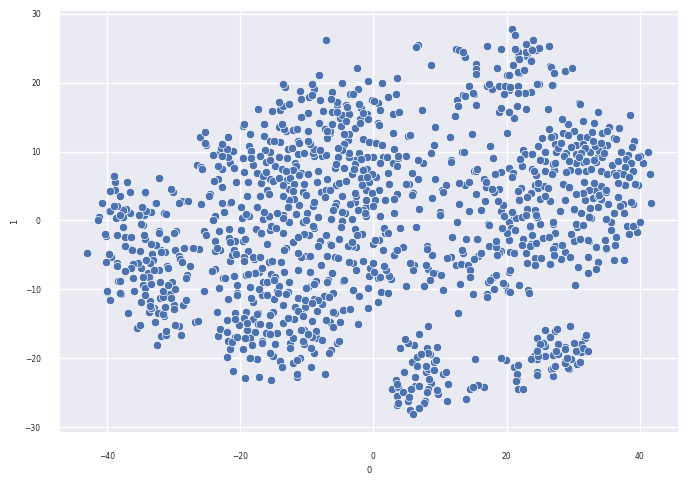

In [485]:
sns.scatterplot(x = tsne_df[0], y = tsne_df[1])

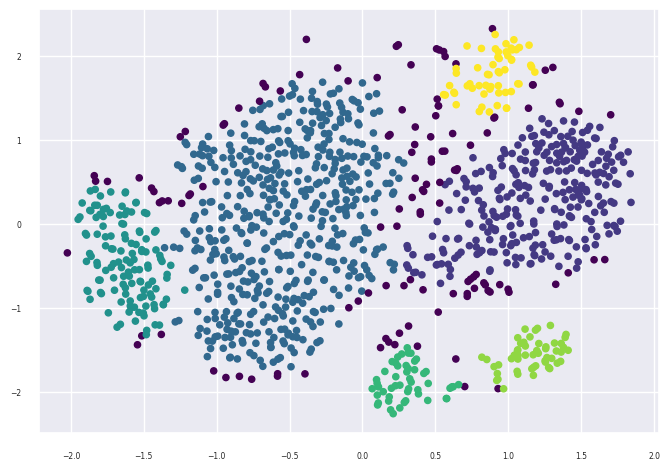

{0, 1, 2, 3, 4, 5, -1}


In [486]:
from sklearn.cluster import DBSCAN

scaler = StandardScaler()

scaled_tsne = scaler.fit_transform(tsne_df)
dbscan = DBSCAN(eps = 0.23, min_samples=20)
dblabels = dbscan.fit_predict(scaled_tsne)

plt.scatter(scaled_tsne[:, 0], scaled_tsne[:, 1], c = dblabels, cmap='viridis', s = 20)
plt.show()
print(set(dblabels))

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.171        13.30%                     13.30%
1              0.116         9.00%                     22.30%


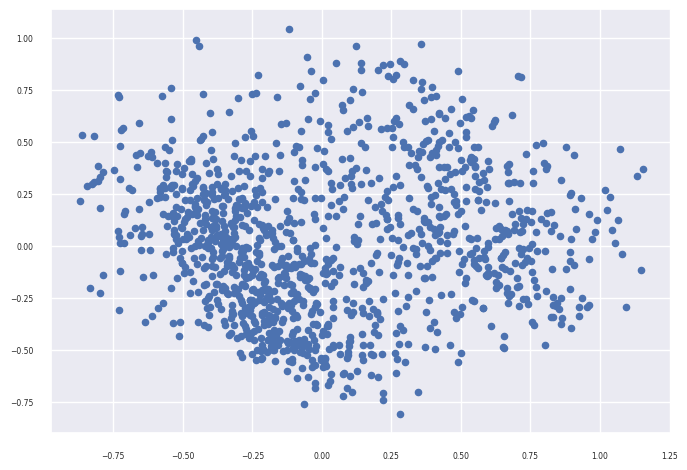

In [487]:
from prince import MCA

mca = MCA(n_components=2)
transformed = mca.fit_transform(no_age)

plt.scatter(transformed[0], transformed[1], s=20)
print(mca.eigenvalues_summary)

[0.12537913 0.09020631]


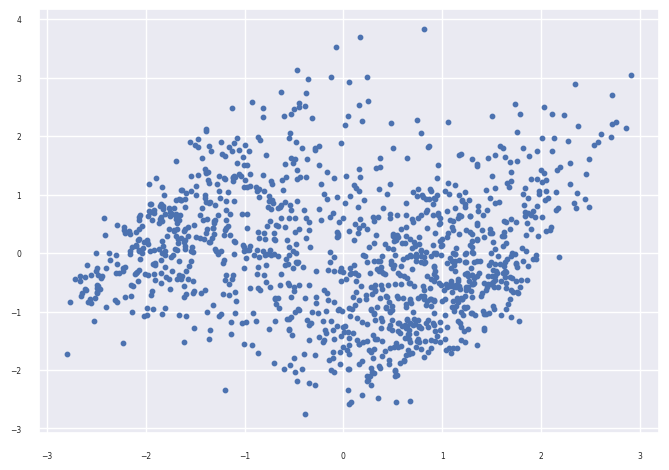

In [488]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(selected)
print(pca.explained_variance_ratio_)

pca_df = pd.DataFrame(pca.fit_transform(selected))

plt.scatter(pca_df[0], pca_df[1], s = 10)

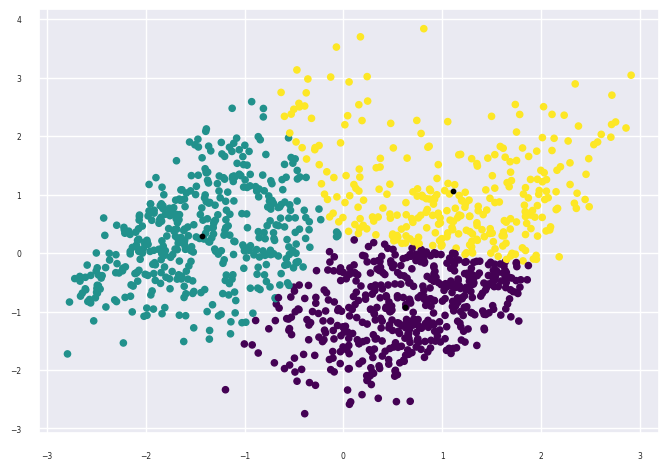

In [489]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto')
labels = kmeans.fit_predict(pca_df)

plt.scatter(pca_df[0], pca_df[1], c=labels, s=20, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', s=10, alpha=1)
plt.show()

In [490]:
df['pca_cluster'] = labels

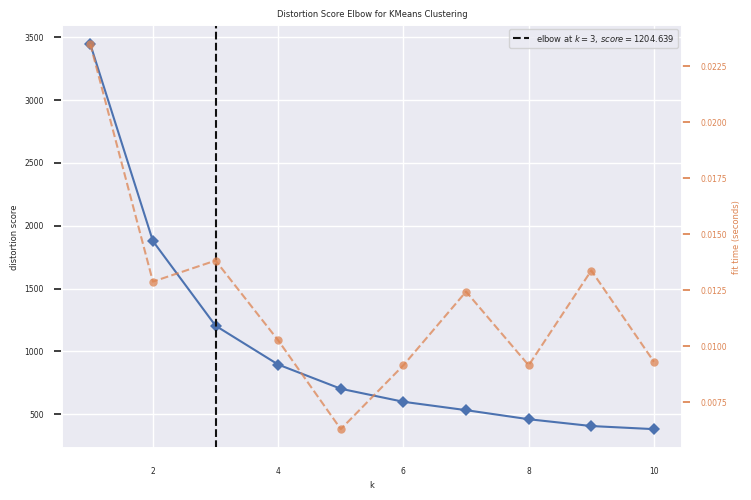

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [491]:
from yellowbrick.cluster import KElbowVisualizer

vis = KElbowVisualizer(KMeans(random_state=0, n_init='auto'), k=(1,11))

vis.fit(pca_df)
vis.show()

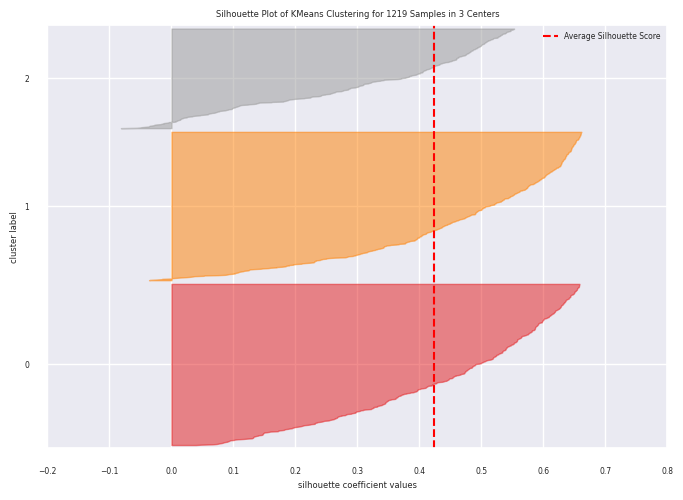

0.4230616676828982


In [492]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
kmeans2 = KMeans(n_clusters=3, n_init='auto')

silh_vis = SilhouetteVisualizer(kmeans2)
silh_vis.fit(pca_df)
silh_vis.show()

print(silhouette_score(pca_df, kmeans2.labels_))

In [493]:
pca_cluster_grp = df.groupby('pca_cluster')

cluster0_df = df.loc[df['pca_cluster'] == 0]
cluster1_df = df.loc[df['pca_cluster'] == 1]
cluster2_df = df.loc[df['pca_cluster'] == 2]

In [495]:
df

,is_self_employed,employee_count_bracket,is_tech_org,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,anon_protec,if_askfor_mh_medical_leave_how_easy,discuss_mh_with_empl_wouldcause_neg_conseq,discuss_ph_with_empl_wouldcause_neg_conseq,empl_takes_mh_asseriously_as_ph,observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,has_prev_employers,prev_empl_provided_mh_benefits,was_aware_of_prevemployers_mhcare_options,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_anon_protec,prev_discuss_mh_with_empl_wouldcause_neg_conseq,prev_discuss_ph_with_empl_wouldcause_neg_conseq,prev_wouldhavebeen_willing_discuss_mh_coworkers,prev_wouldhavebeen_willing_discuss_mh_supervisors,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,willingto_bringup_ph_interview,willingto_bringup_mh_interview,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,hashad_mh_inpast,HAS_MH,hasbeen_diag_byprof,sought_treatment,mh_interferes_w/work_effective_trt,mh_interferes_w/work_ineffective_trt,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,scaled_age,pca_cluster
0,No,26-500,Yes,Not eligible for coverage / N/A,No,No,I don't know,Easy,No,No,I don't know,No,Yes,"No, none did",N/A,I don't know,None did,I don't know,Some or all of them,None of them,Some or all of my previous employers,Some or all of my previous employers,I don't know,None of them,Maybe,Maybe,Maybe,"No, I don't think they would",Open,No,No,Yes,No,Yes,No,Not applicable to me,Not applicable to me,MALE,United Kingdom,Sometimes,Yes,Maybe,0.555333,1
1,No,1-25,Yes,No,Yes,Yes,Yes,Easy,No,No,Yes,No,Yes,Some or all did,I was aware,None did,Some or all did,Yes,None of them,None of them,"No, at none of my previous employers",Some or all of my previous employers,Some or all did,None of them,Maybe,No,"No, I don't think it would","No, I don't think they would",Open,No,Yes,Yes,Yes,Yes,Yes,Rarely,Sometimes,MALE,United States of America,Never,Yes,Maybe,-0.632925,0
2,No,1-25,Yes,No,No,No,I don't know,Neither easy nor difficult,Maybe,No,I don't know,No,Yes,"No, none did",N/A,None did,Some or all did,I don't know,I don't know,Some or all of them,Some or all of my previous employers,I don't know,I don't know,Some or all of them,Yes,Yes,Maybe,Maybe,Open,Maybe/Not sure,No,Maybe,No,No,Yes,Not applicable to me,Not applicable to me,MALE,United Kingdom,Always,Yes,Maybe,0.436507,1
3,Yes,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,Some or all did,N/A,None did,None did,I don't know,Some or all of them,Some or all of them,Some or all of my previous employers,Some or all of my previous employers,I don't know,Some or all of them,Yes,Maybe,"Yes, I think it would",Maybe,Neutral,No,No,Yes,Yes,Yes,Yes,Sometimes,Sometimes,MALE,United Kingdom,Sometimes,No,N/A,1.030636,2
4,No,1-25,No,Yes,No,No,No,Neither easy nor difficult,Yes,Maybe,No,No,Yes,I don't know,N/A,Some or all did,None did,I don't know,Some or all of them,Some or all of them,"No, at none of my previous employers",Some or all of my previous employers,Some or all did,Some or all of them,Maybe,No,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Sometimes,Sometimes,FEMALE,United States of America,Sometimes,Yes,Maybe,1.030636,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,No,500 or more,Yes,Yes,No,No,Yes,Easy,No,No,Yes,No,Yes,Some or all did,I was aware,None did,None did,I don't know,Some or all of them,None of them,Some or all of my previous employers,"No, at none of my previous employers",None did,Some or all of them,No,No,Maybe,"No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Rarely,Often,FEMALE,United States of Ameri

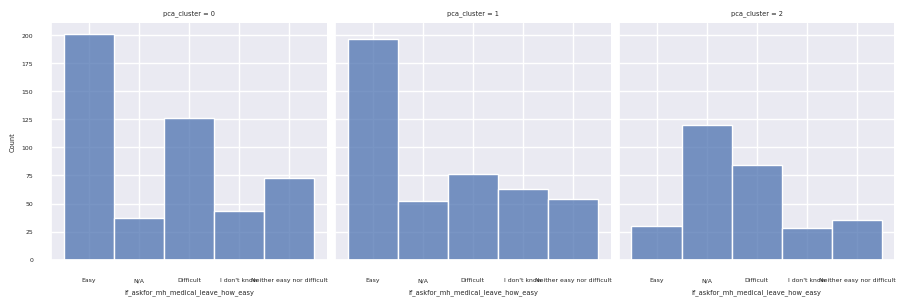

In [503]:
sns.set(font_scale=0.4)
grid = sns.FacetGrid(data = df, col='pca_cluster')
grid.map(sns.histplot, 'if_askfor_mh_medical_leave_how_easy')

PCA CLUSTERS:

self_empl: C0 50/50, rest employed
tech_org: C0 and C1 mostly yes, C2 dist evenly
coverage: C0 and C1 mostly yes and dunno, C2 mostly N/A
discussed_mh: all mostly no, C2 split between no and N/A
offers_resrc: 
